In [92]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Load credentials
load_dotenv()

True

In [84]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [101]:
# SQL query
sql = """
WITH sales_per_store_per_week AS (
    SELECT
        store_id,
        date_id,
        SUM(store_weekly_sales) AS sales_per_store_per_week
    FROM
        WALMART_DB.SILVER.walmart_fact_table
    GROUP BY
        1,2
)
SELECT
    wsd.store_id,
    wsd.store_size,
    AVG(pspw.sales_per_store_per_week) AS average_weekly_sales_per_store
FROM
    sales_per_store_per_week pspw
JOIN
    WALMART_DB.SILVER.walmart_store_dim wsd
ON
    pspw.store_id = wsd.store_id
GROUP BY
    1,2
ORDER BY
    1,2
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)

# Convert the store size to a string 
# plotly create a more managable range for the y-axis
# df['store_size'] = df['store_size'].astype(str)


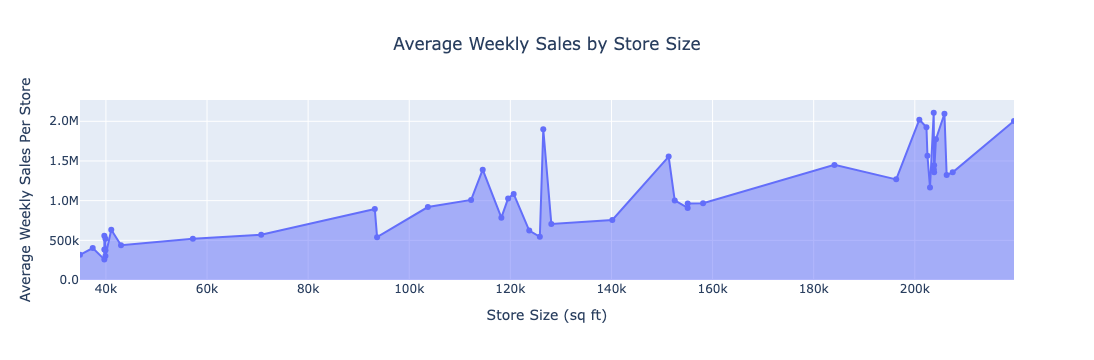

In [86]:
# THIS CHART IS FOR ACTUAL WEEKLY SALES, IGNORING DUPLICATE STORE SIZES
# Plot using Plotly
fig = px.area(
    df,
    x='store_size',
    y='average_weekly_sales_per_store',
    title='Average Weekly Sales by Store Size',
    labels={
        'store_size': 'Store Size (sq ft)',
        'average_weekly_sales_per_store': 'Average Weekly Sales Per Store'
    }
)

# Add markers to help visualize key points and facillitate hover for details
fig.update_traces(mode="lines+markers", fill='tozeroy', line_shape='linear', opacity=0.8)

# Center the title
fig.update_layout(title_x=0.5)

fig.update_layout(yaxis_tickformat=".2s")


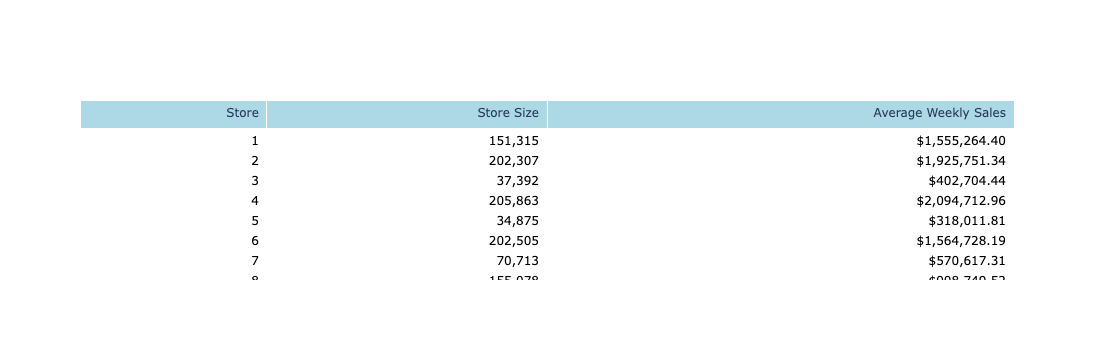

In [87]:
df_weekly_sales = df.copy()

# Convert the store_size column to a string so the total row does not try to coerce a blank to an integer value
df_weekly_sales['store_size'] = df_weekly_sales['store_size'].apply(lambda x: f"{int(x):,}" if x != '' else '')

# Create a separate total_row dataframe
df_total_row = pd.DataFrame([{
    'store_id':'Total',
    'store_size': '',
    'average_weekly_sales_per_store': df_weekly_sales['average_weekly_sales_per_store'].sum()
}])

# Append the total row to the dataframe
df_weekly_sales = pd.concat([df_weekly_sales, df_total_row], ignore_index=True)

# Let's make the total row bold. To do that, each column needs to be of type 
# String so we can apply an HTML tag <b> on it to make it bold.
df_weekly_sales['store_id'] = df_weekly_sales['store_id'].astype(str)
df_weekly_sales['average_weekly_sales_per_store'] = df_weekly_sales['average_weekly_sales_per_store'].apply(lambda x: f"${x:,.2f}" if x != '' else '')

# Now add a bold tag to the total row.  Loop through each column in the last row
# and surround it with the <b></b> tags. Don't be confused by the statement:
# df_weekly_sales.iloc[-1][col]
# This is chaining 2 statements together to fetch the last row first (as a series), then
# fetching the label-based element associated with the variable "col" to get the specific
# element.
for col in df_weekly_sales.columns:
    df_weekly_sales.loc[len(df_weekly_sales)-1, col] = f"<b>{df_weekly_sales.iloc[-1][col]}</b>"

# Format the weekly_sales number to look like currency
#df_weekly_sales['total_weekly_sales': df_weekly_sales['total_weekly_sales'].sum()] = df_weekly_sales['total_weekly_sales'].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
#print(df_weekly_sales)

# Create a plotly table from the dataframe
fig_summary = go.Figure(
    data = [go.Table(
        columnwidth=[10, 15, 25],
        header=dict(
            values=["Store", "Store Size", "Average Weekly Sales"],
            fill_color="lightblue",
            align=['right', 'right', 'right']
        ),
        cells=dict(
            values=[df_weekly_sales[col] for col in df_weekly_sales.columns],
            # format=["", "", ",.2f"],
            align=["right","right","right"],
            # prefix=["", "", "$"],
            fill_color=[["white"] * (len(df_weekly_sales)-1) + ["lavender"]] * 3,
            font=dict(color=["black"] * (len(df_weekly_sales)-1) + ["black"])
        ),
    )]
)

fig_summary.show()

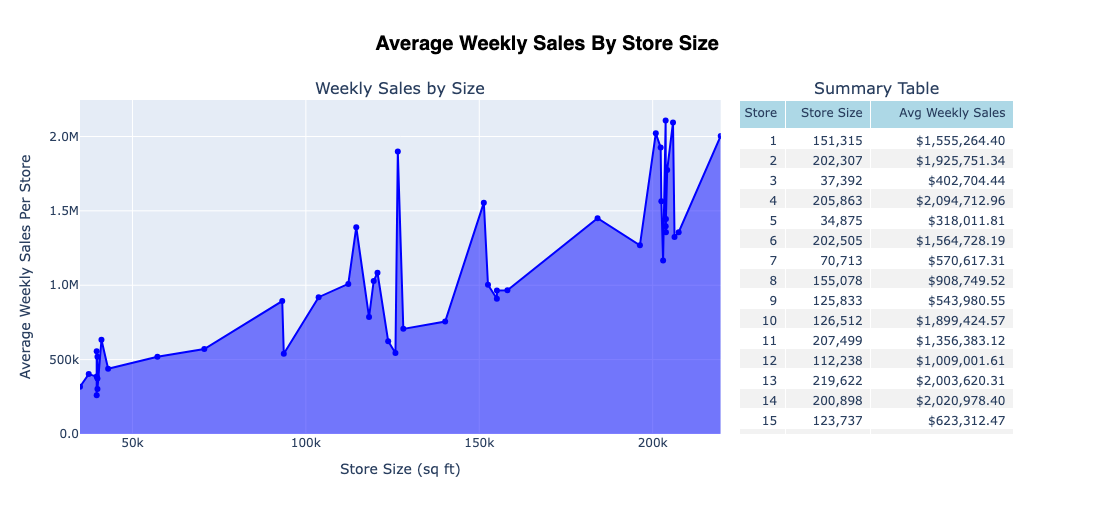

In [141]:
# Let's combine the graph and the summary table into a single dashboard-style presentation

# First, set up the overall container for the charts
fig = make_subplots(
    rows=1,
    cols=2,
    column_widths=[0.70, 0.30],
    # vertical_spacing = 0.2, 
    horizontal_spacing=0.02,  # reduce the gutter between col1 and col2
    subplot_titles=("Weekly Sales by Size", "Summary Table"),
    # specs=[[{"type": "xy"}, {"type": "table"}]],
    specs=[
        [{'type':"xy", 't':0, 'b':0}, {"type": "table", 't': 0, 'b': 0}]
    ],

)

# ====================================
# Line Area Chart

# Add the area-style line chart to column 1. We use go.Scatter here instead of px.area.
# Important: sort the data by x-axis values to avoid a "spaghetti" graph.
df_sorted = df.sort_values(by="store_size", ascending=True)

area_trace = go.Scatter(
    x=df_sorted['store_size'],
    y=df_sorted['average_weekly_sales_per_store'],
    mode='lines+markers',         # enables lines with dots on each point
    fill='tozeroy',               # fills the area under the line
    line=dict(color='blue'),
    name="Average Weekly Sales",
    line_shape='linear',
    opacity=0.8,
    # customdata = f"{(FLOOR([[x]]) * 1000)}K" * len(df_subset),
    hovertemplate='Store Size: %{x:,} sq ft<br>Average Weekly Sales: %{y:$,.2f}<extra></extra>'
)

# ====================================
# Summary Table
fig.add_trace(area_trace, row=1, col=1)

# Prepare zebra striping for the summary table
# Alternate row colors: white for even, light gray for odd.
# We build color lists for each column, with the last row (the total row) as white.
fill_colors = [
    ['white' if i % 2 == 0 else '#f2f2f2' for i in range(len(df_weekly_sales) - 1)] + ['white']
    for _ in range(3)
]

# Overwrite the fill color of the final row (the Total row) to a distinct color for emphasis
for i in range(len(fill_colors)):
    fill_colors[i][-1] = 'lavender'

# Add the summary table to column 2
fig.add_trace(
    go.Table(
        columnwidth=[8, 15, 25],
        header=dict(
            values=["Store", "Store Size", "Avg Weekly Sales"],
            fill_color="lightblue",
            align=['right', 'right', 'right']
        ),
        cells=dict(
            values=[df_weekly_sales[col] for col in df_weekly_sales.columns],
            align=["right", "right", "right"],
            fill_color=fill_colors
        )
    ),
    row=1,
    col=2
)

# Final layout adjustments
fig.update_layout(
    height = 500,
    width = 1150,
    title='Average Weekly Sales by Store Size',
    title_x=0.5,
    xaxis_title='Store Size (sq ft)',
    yaxis_title='Average Weekly Sales Per Store',
    yaxis_tickformat=".2s"
)

# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
fig.update_layout(title=dict(text='Average Weekly Sales By Store Size', x=0.5, font=title_font))


fig.show()


In [ ]:
# Close the connection
conn.close()